# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st
from scipy.stats import ttest_ind

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

<font color=#008000>1.1 Внимательно посмотрим на 'calls'.</font>

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


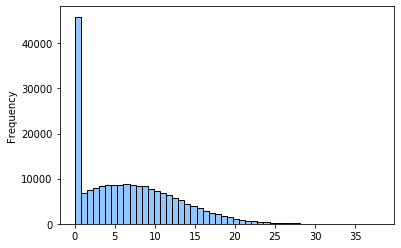

In [5]:
plt.style.use('seaborn-pastel')
calls['duration'].plot(kind = 'hist', ec = 'black', bins = 50)

Пропусков в 'calls' нет. Нужно перевести даты в колонке call_date в datetime. Также в колонке duration слишком много звонков длительностью 0 секунд. Нужно будет с этим разобраться.

<font color=#008000>1.2 Внимательно посмотрим на 'internet'.</font>

In [6]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


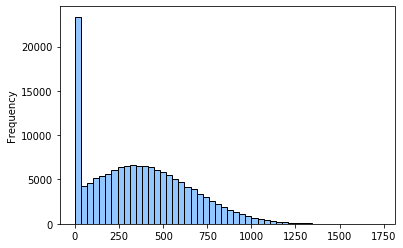

In [8]:
plt.style.use('seaborn-pastel')
internet['mb_used'].plot(kind = 'hist', ec = 'black', bins = 50)

Пропусков в данных нет. Необходимо изменить тип данных в session_date на datetime. Также в колонке mb_used слишком много строк с нулевым трафиком. Нужно будет с этим разобраться.

<font color=#008000>1.3 Внимательно посмотрим на 'messages'.</font>

In [9]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропусков нет. Нужно перевести колонку message_date в datetime.

<font color=#008000>1.4 Внимательно посмотрим на 'messages'.</font>

In [11]:
tariffs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Всего 2 позиции: данные о тарифах

<font color=#008000>1.5 Внимательно посмотрим на 'users'.</font>

In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Присутствует большое количество пропусков в колонке churn_date - дата прекращения тарифа. Но из условия задачи мы знаем, что если в этой колонке есть пропуск, то у этого клиента "Мегалайна", на момент выгрузки данных, тариф ещё действовал. Эти пропуски нам не помешают.
Также нужно будет изменить тип данных в колонке reg_date на datetime.

# Шаг 2. Подготовьте данные

<font color=#008000>2.1 Приведите данные к нужным типам.</font>

В каждой таблице, кроме 'tariffs', есть колонка с датами:

- call_date в 'calls'
- session_date в 'internet'
- message_date в 'messages'
- ref_date в 'users'

Переведём данные в этих колонка в datetime, а также добавим колонки 'месяц'.

In [14]:
def date_to_datetime_and_month(dataframes):
    for df in dataframes:
        for column in df.columns:
            if 'date' in column and column != 'churn_date':
                df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
                df['месяц'] = df[column].apply(lambda x: x.month)

In [15]:
date_to_datetime_and_month([calls, internet, messages, users])

Проверим результат.

In [16]:
calls.head()

,id,call_date,duration,user_id,месяц
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [17]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
месяц        202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


In [18]:
internet.head()

,id,mb_used,session_date,user_id,месяц
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [19]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
месяц           149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [20]:
messages.head()

,id,message_date,user_id,месяц
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [21]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
месяц           123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


In [22]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,месяц
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


In [23]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
месяц         500 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 35.3+ KB


Нужные нам даты переведены в datetime, и у нас есть колонки с месяцами.

<font color='blue'> Хорошо. </font>

<font color=#008000>2.2 Найдите и исправьте ошибки в данных.</font>

Мы узнали, что в колонках calls['duration'] и internet['mb_used'] очень много околонулевых значений.

Сначала разберёмся с calls['duration'].

In [24]:
calls.head()

,id,call_date,duration,user_id,месяц
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Из условия задания мы знаем, что если клиент проговорил даже 1 секунду, то по тарифу засчитается целая минута. Округлим все околонулевые значения в колонке 'duration'.

In [25]:
calls['duration'] = calls['duration'].apply(np.ceil)

In [26]:
calls.head()

,id,call_date,duration,user_id,месяц
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


Построим гистограмму распределения.

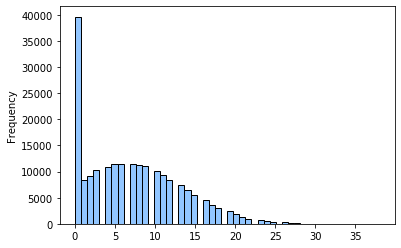

In [27]:
plt.style.use('seaborn-pastel')
calls['duration'].plot(kind = 'hist', ec = 'black', bins = 50)

После округления могли остаться только нулевые значения. Посмотрим на них.

In [28]:
calls.query('duration == 0')

,id,call_date,duration,user_id,месяц
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
9,1000_9,2018-08-15,0.0,1000,8
...,...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499,12
202592,1499_205,2018-10-13,0.0,1499,10
202593,1499_206,2018-12-26,0.0,1499,12
202594,1499_207,2018-10-28,0.0,1499,10


Возможно, это не состоявшиеся, по причине недоступности или занятости абонента, звонки. Такие звонки не расходуют тариф, и для для дальнеёшего подсчёта выручки и потребления они нам не понадобятся. Заменим нули на 'NaN, и построим гистограмму.

In [29]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

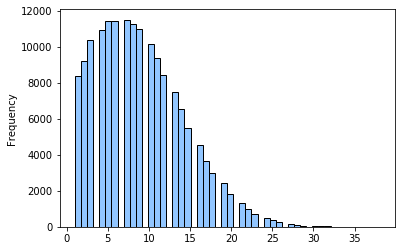

In [30]:
calls['duration'].plot(kind='hist', ec='black', bins=50)

Теперь internet['mn_used'].

Также как и с минутами, мегабайты округляются в большую сторону.

In [31]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.head()

,id,mb_used,session_date,user_id,месяц
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9


Построим гистограмму.

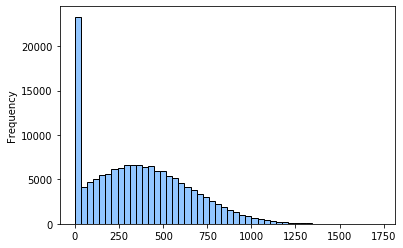

In [32]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50)

После округления осталось много нулевых значений. Посмотрим на них.

In [33]:
internet.query('mb_used == 0')

,id,mb_used,session_date,user_id,месяц
11,1000_11,0.0,2018-08-28,1000,8
38,1000_38,0.0,2018-11-27,1000,11
46,1000_46,0.0,2018-06-30,1000,6
67,1000_67,0.0,2018-06-16,1000,6
72,1000_72,0.0,2018-06-15,1000,6
...,...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499,12
149381,1499_142,0.0,2018-11-01,1499,11
149383,1499_144,0.0,2018-11-27,1499,11
149386,1499_147,0.0,2018-10-21,1499,10


Сессии с нулевым потреблением трафика могли появится, когда клиент подключался к сети, но не проводил никаких операция. Также как звонки с нулевой длительностью, сессии с нулевым потреблением трафика нам будут только мешать. Избавимся от них, и построим график.

In [34]:
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

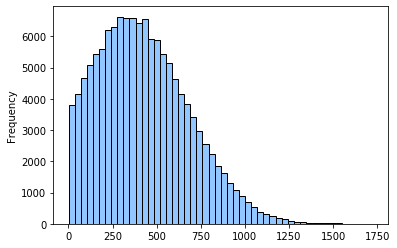

In [35]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50)

<font color=#008000>2.3 Посчитайте количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, и помесячную выручку с каждого пользователя.</font>

Сначала мы создадим таблицу, которая соберёт в себе общую информацию о каждом клиенте: какой у него тариф, сколько звонков он сделал, количество СМС и т.д.

In [36]:
calls_amount = calls.groupby(['user_id', 'месяц'])['duration'].agg(['count', 'sum'])
messages_amount = messages.groupby(['user_id', 'месяц'])['id'].count()
internet_amount = internet.groupby(['user_id', 'месяц']).sum()['mb_used']

client_actions_amount = pd.concat([calls_amount, messages_amount, internet_amount], axis = 1)
client_actions_amount = client_actions_amount.reset_index()
client_actions_amount.head()

,user_id,месяц,count,sum,id,mb_used
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0


Добавим в таблицу колонку с тарифами.

In [37]:
dict_user_tarif = dict(pd.Series(users['tariff'].values, index = users['user_id']))
client_actions_amount['Тариф'] = client_actions_amount['user_id'].map(dict_user_tarif)

Добавим в таблицу колонку с городами клиентов.

In [38]:
dict_user_city = dict(pd.Series(users['city'].values, index = users['user_id']))
client_actions_amount['Город'] = client_actions_amount['user_id'].map(dict_user_city)

Переименуем колонки.

In [39]:
client_actions_amount.columns = ['User_id', 'Месяц', 'Количество звонков', 
                                 'Длительность звонков в мин.', 'СМС', 'Интернет', 'Тариф', 'Город']

Посмотрим на таблицу.

In [40]:
client_actions_amount.head(10)

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар
5,1000,10,44.0,350.0,73.0,14717.0,ultra,Краснодар
6,1000,11,37.0,338.0,58.0,14768.0,ultra,Краснодар
7,1000,12,38.0,333.0,70.0,9827.0,ultra,Краснодар
8,1001,11,45.0,430.0,NaN,18452.0,smart,Москва
9,1001,12,47.0,414.0,NaN,14053.0,smart,Москва


In [41]:
client_actions_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
User_id                        3214 non-null int64
Месяц                          3214 non-null int64
Количество звонков             3168 non-null float64
Длительность звонков в мин.    3168 non-null float64
СМС                            2717 non-null float64
Интернет                       3201 non-null float64
Тариф                          3214 non-null object
Город                          3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 201.0+ KB


Видим, что в таблице есть пропуски. Осмотрим их.

In [42]:
client_actions_amount[client_actions_amount['Количество звонков'].isnull()]

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город
570,1091,5,NaN,NaN,30.0,10714.0,ultra,Набережные Челны
571,1091,6,NaN,NaN,30.0,10245.0,ultra,Набережные Челны
572,1091,7,NaN,NaN,35.0,16460.0,ultra,Набережные Челны
573,1091,8,NaN,NaN,31.0,12644.0,ultra,Набережные Челны
574,1091,9,NaN,NaN,32.0,16611.0,ultra,Набережные Челны
575,1091,10,NaN,NaN,44.0,15659.0,ultra,Набережные Челны
576,1091,11,NaN,NaN,28.0,11876.0,ultra,Набережные Челны
577,1091,12,NaN,NaN,42.0,13292.0,ultra,Набережные Челны
671,1106,4,NaN,NaN,9.0,2925.0,ultra,Калуга
672,1106,5,NaN,NaN,28.0,16591.0,ultra,Калуга


In [43]:
client_actions_amount[client_actions_amount['Длительность звонков в мин.'].isnull()]

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город
570,1091,5,NaN,NaN,30.0,10714.0,ultra,Набережные Челны
571,1091,6,NaN,NaN,30.0,10245.0,ultra,Набережные Челны
572,1091,7,NaN,NaN,35.0,16460.0,ultra,Набережные Челны
573,1091,8,NaN,NaN,31.0,12644.0,ultra,Набережные Челны
574,1091,9,NaN,NaN,32.0,16611.0,ultra,Набережные Челны
575,1091,10,NaN,NaN,44.0,15659.0,ultra,Набережные Челны
576,1091,11,NaN,NaN,28.0,11876.0,ultra,Набережные Челны
577,1091,12,NaN,NaN,42.0,13292.0,ultra,Набережные Челны
671,1106,4,NaN,NaN,9.0,2925.0,ultra,Калуга
672,1106,5,NaN,NaN,28.0,16591.0,ultra,Калуга


In [44]:
client_actions_amount[client_actions_amount['СМС'].isnull()]

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город
8,1001,11,45.0,430.0,NaN,18452.0,smart,Москва
9,1001,12,47.0,414.0,NaN,14053.0,smart,Москва
42,1006,2,3.0,42.0,NaN,1395.0,smart,Ульяновск
43,1006,3,36.0,286.0,NaN,17309.0,smart,Ульяновск
44,1006,4,38.0,356.0,NaN,13954.0,smart,Ульяновск
...,...,...,...,...,...,...,...,...
3181,1494,8,26.0,262.0,NaN,6601.0,smart,Омск
3182,1494,9,57.0,501.0,NaN,16986.0,smart,Омск
3183,1494,10,45.0,354.0,NaN,17794.0,smart,Омск
3184,1494,11,46.0,411.0,NaN,18076.0,smart,Омск


In [45]:
client_actions_amount[client_actions_amount['Интернет'].isnull()]

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город
592,1094,5,12.0,107.0,3.0,NaN,ultra,Новосибирск
1722,1273,5,19.0,220.0,21.0,NaN,ultra,Курган
1723,1273,6,28.0,230.0,38.0,NaN,ultra,Курган
1724,1273,7,30.0,253.0,37.0,NaN,ultra,Курган
1725,1273,8,39.0,253.0,41.0,NaN,ultra,Курган
1726,1273,9,28.0,223.0,32.0,NaN,ultra,Курган
1727,1273,10,35.0,315.0,35.0,NaN,ultra,Курган
1728,1273,11,31.0,272.0,29.0,NaN,ultra,Курган
1729,1273,12,38.0,260.0,39.0,NaN,ultra,Курган
2306,1365,10,5.0,43.0,1.0,NaN,smart,Ростов-на-Дону


У одних клиентов есть пропуски в звонках, а у других в СМС. Проверим, есть ли клиенты с пропусками во всех услугах: звонках, СМС и интернете.

In [46]:
client_actions_amount[(client_actions_amount['Длительность звонков в мин.'].isnull()) & (client_actions_amount['СМС'].isnull())
                     & (client_actions_amount['Интернет'].isnull())]

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город


Таких клиентов нет. Значит эти пропуски означают, что клиенты иногда не пользовались определёнными типами связи. Заполним эти пропуски нулями.

In [47]:
client_actions_amount = client_actions_amount.fillna(0)

In [48]:
client_actions_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
User_id                        3214 non-null int64
Месяц                          3214 non-null int64
Количество звонков             3214 non-null float64
Длительность звонков в мин.    3214 non-null float64
СМС                            3214 non-null float64
Интернет                       3214 non-null float64
Тариф                          3214 non-null object
Город                          3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 201.0+ KB


Теперь добавим в таблицу информацию о выручке с каждого клиента.

Для этого нужно высчитать и добавить в таблицу следующие колонки:

- Абонентская плата
- Минуты сверх лимита
- СМС сверх лимита
- МБ сверх лимита
- Плата сверх лимита
- Сумма выручки за месяц

Добавим в таблицу колонку 'Абонентская плата', создав словарь с ценами каждого тарифа, и применив метод .map() на колонку 'Тариф'.

In [49]:
month_price = {'smart': 550, 'ultra': 1950}
client_actions_amount['Абонентская плата'] = client_actions_amount['Тариф'].map(month_price)

Для добавления колонки 'Минуты сверх лимита' напишем функцию.

In [50]:
def minutes_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Длительность звонков в мин.'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['Длительность звонков в мин.'] - 3000
        return np.where(result > 0, result, 0)
    
client_actions_amount['Минуты сверх лимита'] = client_actions_amount.apply(minutes_over_plan, axis = 1)

Напишем функцию для добавленя колонки 'СМС сверх лимита'.

In [51]:
def sms_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['СМС'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['СМС'] - 1000
        return np.where(result > 0, result, 0)
    
client_actions_amount['СМС сверх лимита'] = client_actions_amount.apply(sms_over_plan, axis = 1)

Напишем функцию для добавления колонки 'МБ сверх лимита'.

In [52]:
def Mb_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Интернет'] - 15 * 1024
        return np.where(result > 0, result, 0)
    else:
        result = row['Интернет'] - 30 * 1024
        return np.where(result > 0, result, 0)
    
client_actions_amount['МБ сверх лимита'] = client_actions_amount.apply(Mb_over_plan, axis = 1)

Напишем функцию для добавления колонки 'Плата сверх лимита'.

In [53]:
def month_payment(row):
    sum_per_month = 0
    if row['Тариф'] == 'smart':
        sum_per_month += np.ceil(row['Минуты сверх лимита']) * 3
        sum_per_month += row['СМС сверх лимита'] * 3
        sum_per_month += np.ceil(row['МБ сверх лимита']/1024) * 200
        return sum_per_month
    
    else:
        sum_per_month += np.ceil(row['Минуты сверх лимита']) * 1
        sum_per_month += row['СМС сверх лимита'] * 1
        sum_per_month += np.ceil(row['МБ сверх лимита']/1024) * 150
        return sum_per_month
    
client_actions_amount['Плата сверх лимита'] = client_actions_amount.apply(month_payment, axis = 1)

Теперь создадим колонку 'Сумма выручки за месяц', сложив данные из колонок 'Абонентская плата' и 'Плата сверх лимита'

In [54]:
client_actions_amount['Сумма выручки за месяц'] = client_actions_amount['Абонентская плата'] + client_actions_amount['Плата сверх лимита']

Посмотрим на получившуюся таблицу.

In [55]:
client_actions_amount.head()

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город,Абонентская плата,Минуты сверх лимита,СМС сверх лимита,МБ сверх лимита,Плата сверх лимита,Сумма выручки за месяц
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0.0,0.0,0.0,1950.0
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0.0,0.0,0.0,1950.0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0.0,0.0,0.0,1950.0
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0.0,0.0,0.0,1950.0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0.0,0.0,0.0,1950.0


Переведём колонки 'СМС сверх лимита', 'Плата сверх лимита' и 'Сумма выручки за месяц' в тип int, а 'Минуты сверх лимита' и 'МБ сверх лимита' в тип float.

In [56]:
client_actions_amount['СМС сверх лимита'] = client_actions_amount['СМС сверх лимита'].astype(int)
client_actions_amount['Плата сверх лимита'] = client_actions_amount['Плата сверх лимита'].astype(int)
client_actions_amount['Сумма выручки за месяц'] = client_actions_amount['Сумма выручки за месяц'].astype(int)
client_actions_amount['Минуты сверх лимита'] = client_actions_amount['Минуты сверх лимита'].astype(float)
client_actions_amount['МБ сверх лимита'] = client_actions_amount['МБ сверх лимита'].astype(float)

In [57]:
client_actions_amount.head()

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город,Абонентская плата,Минуты сверх лимита,СМС сверх лимита,МБ сверх лимита,Плата сверх лимита,Сумма выручки за месяц
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950


##### Вывод 2

Мы перевели в datetime следующие колонки:
- call_date в 'calls'
- session_date в 'internet'
- message_date в 'messages'
- ref_date в 'users'

Также в эти таблицы были добавлены колонка 'месяц'.

В колонках calls['duration'] и internet['mb_used'] было обнаружино множество околонулевых значений. После анализа мы пришли к выводу, что они появились в следствии того, что клиенты иногда просто не пользовались определёнными типами связи. Эти значения были заменены на NaN.

Также мы создали таблицу client_actions_amount, собирающую в себе следующую информацию о клиентах:
- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя

# Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.



<font color=#008000>3.1 Найдите выбросы по данным: 'Длительность звонков в мин.', 'СМС', 'Интернет'.</font>

Для этого мы построем функцию, строющую гистограммы размаха, на основании заранее заданных нижних и верхних значений усов.

In [58]:
def plot_box(whis):
    rows = 1
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(40,15))
    column_list = ['Длительность звонков в мин.', 'СМС', 'Интернет']
    column_list_count = 0
    
    for r in range(rows):
        for c in range(cols):
            ax = client_actions_amount.boxplot(column = column_list[column_list_count], by = 'Тариф', fontsize=40,
                                               ax = axes[c], notch = True, whis = whis)
            ax.set_title(column_list[column_list_count])
            ax.title.set_size(40)
            ax.set_xlabel('')
            plt.suptitle('Boxplot с whis = {}'.format(whis), y=1, fontsize=45, fontweight='bold')
            column_list_count += 1

Создадим гистограммы размаха со стандартным межквартильным размахом - 1.5

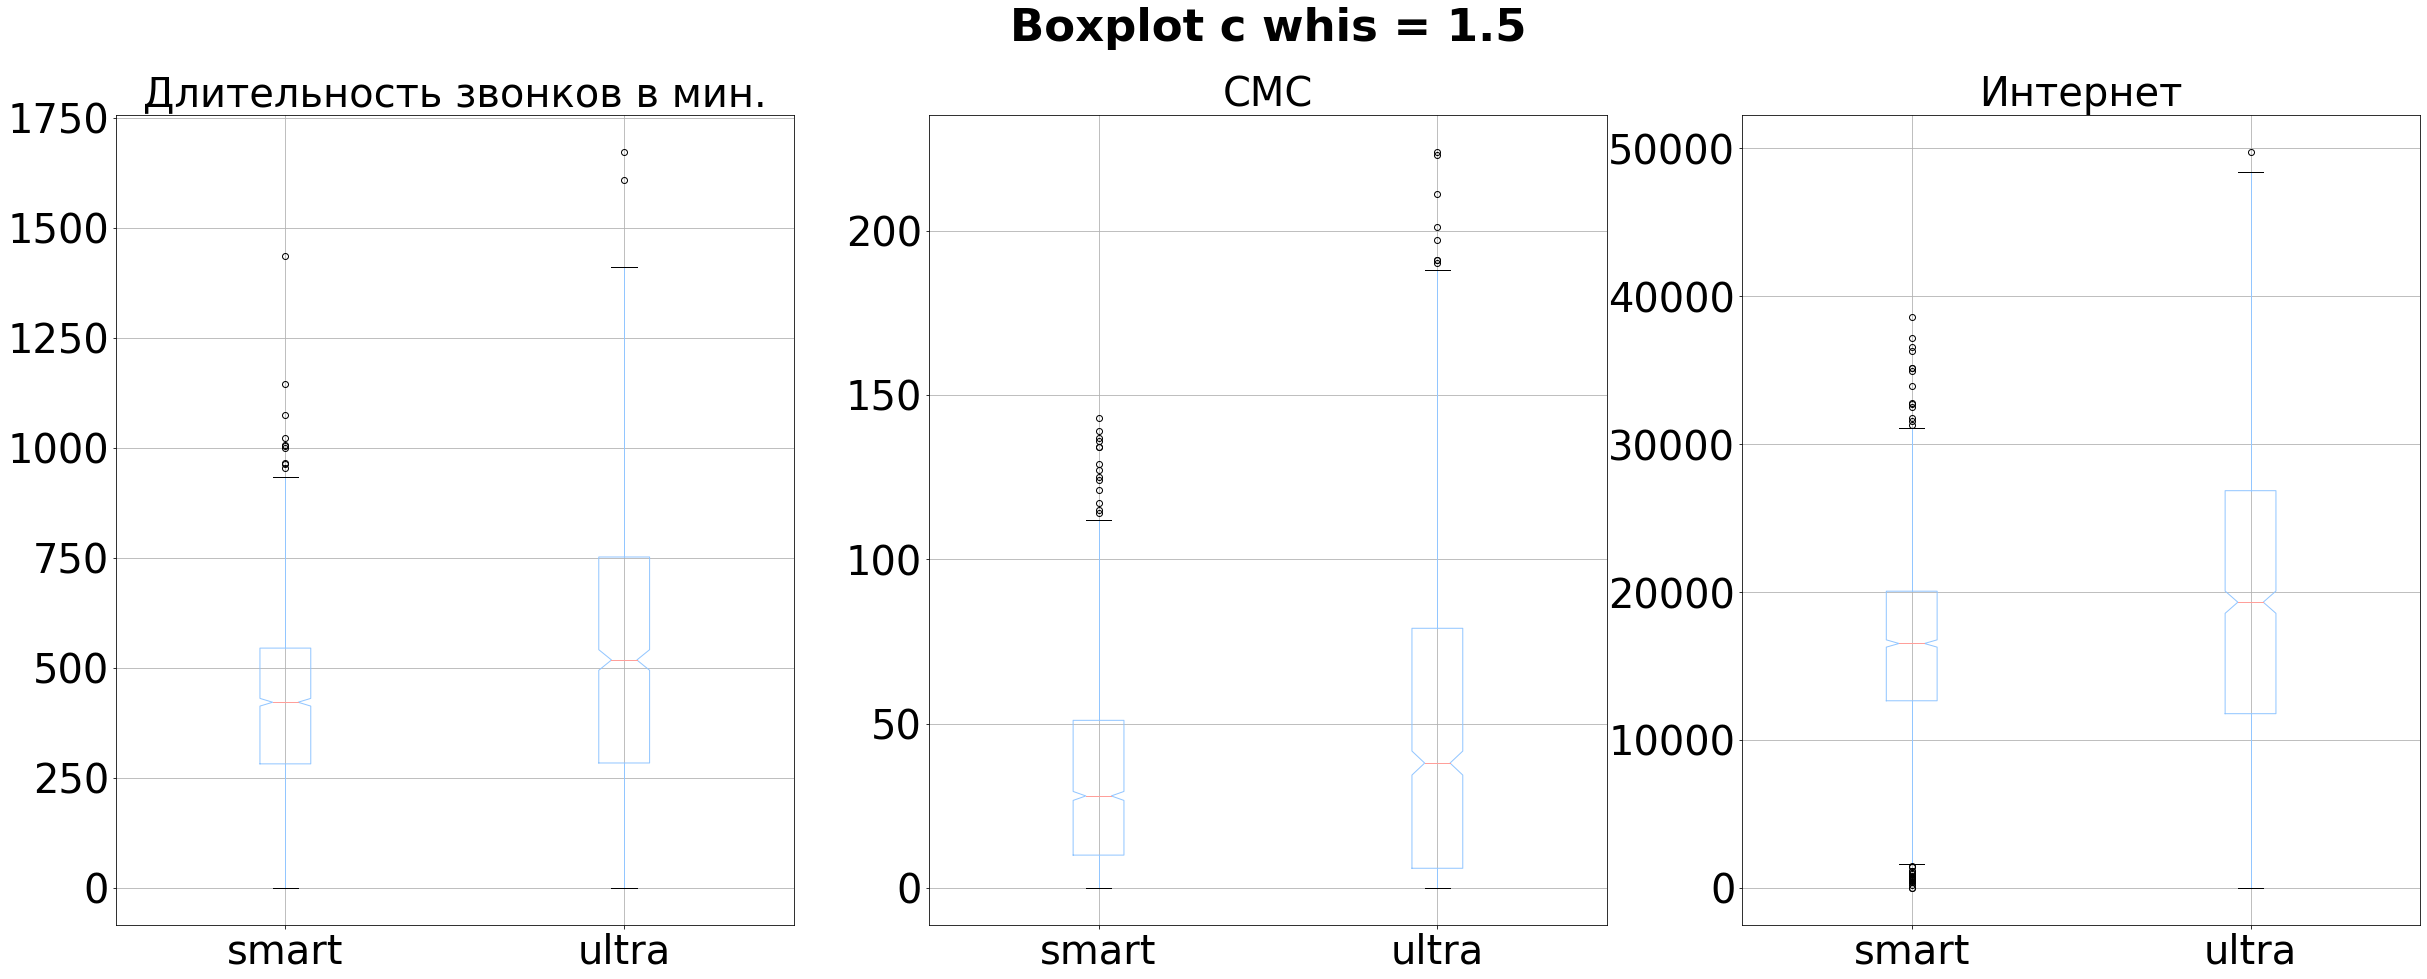

In [59]:
plot_box(1.5)

Теперь построим функцию для расчёта интервалов из гистограмм размаха, которые вы можете увидеть выше.

In [60]:
def intervals(column, data_filter):
    
    if data_filter == 'Тариф':
        format_name = column
        data1, data2 = 'smart', 'ultra'
        format_end1 = 'тарифа "Смарт"'
        format_end2 = 'тарифа "Ультра"'
    elif data_filter == 'Москвич':
        format_name = 'Москвич'
        data1, data2 = 0, 1
        format_end1 = 'для регионов'
        format_end2 = 'для Москвы'
    
    q1_1 = client_actions_amount[client_actions_amount[data_filter] == data1][column].quantile(0.25)
    q3_1 = client_actions_amount[client_actions_amount[data_filter] == data1][column].quantile(0.75)
    diff_1 = q3_1 - q1_1
    
    if data_filter == 'Москвич':
        left_int_1 = np.where( (q1_1 - 1.5 * diff_1) > 550, q1_1 - 1.5 * diff_1, 550)
    else:
        left_int_1 = np.where( (q1_1 - 1.5 * diff_1) > 0, q1_1 - 1.5 * diff_1, 0)
    
    right_int_1 = np.where( (q3_1 + 1.5 * diff_1) > 0, q3_1 + 1.5 * diff_1, 0)
    
    q1_2 = client_actions_amount[client_actions_amount[data_filter] == data2][column].quantile(0.25)
    q3_2 = client_actions_amount[client_actions_amount[data_filter] == data2][column].quantile(0.75)
    diff_2 = q3_2 - q1_2
    
    if data_filter == 'Москвич':
        left_int_2 = np.where( (q1_2 - 1.5 * diff_2) > 550, q1_2 - 1.5 * diff_2, 550)
    else:
        left_int_2 = np.where( (q1_2 - 1.5 * diff_2) > 0, q1_2 - 1.5 * diff_2, 0)
        
    right_int_2 = np.where( (q3_2 + 1.5 * diff_2) > 0, q3_2 + 1.5 * diff_2, 0)
    
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column, format_end1, left_int_1, right_int_1))
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column, format_end2, left_int_2, right_int_2))
    
    return (left_int_1, right_int_1), (left_int_2, right_int_2)

Найдём границы для 'Длительность звонков в мин.'

In [61]:
calls_int_smart, calls_int_ultra = intervals('Длительность звонков в мин.', 'Тариф')

Границы интервала для столбца "Длительность звонков в мин." тарифа "Смарт": 0.0 - 939.5
Границы интервала для столбца "Длительность звонков в мин." тарифа "Ультра": 0.0 - 1454.0


Теперь границы для 'СМС'

In [62]:
sms_int_smart, sms_int_ultra = intervals('СМС', 'Тариф')

Границы интервала для столбца "СМС" тарифа "Смарт": 0.0 - 112.5
Границы интервала для столбца "СМС" тарифа "Ультра": 0.0 - 188.5


Теперь границы для 'Интернет'

In [63]:
internet_int_smart, internet_int_ultra = intervals('Интернет', 'Тариф')

Границы интервала для столбца "Интернет" тарифа "Смарт": 1543.0 - 31183.0
Границы интервала для столбца "Интернет" тарифа "Ультра": 0.0 - 49480.0


<font color=#008000>3.2 Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.</font>


Построим гистограммы по тарифам по длительности звонков, по количеству отправленных смс, по количеству потраченного интернет-трафика. Помимо этого, выведем на расчетные данные по среднему, дисперсии и стандартному отклонению:

In [64]:
def plot_hist_comparison(data):
    
    ax = plt.gca()
    func_dict = {'Звонки': 'Длительность звонков в мин.', 'СМС': 'СМС', 'Интернет': 'Интернет'}
    xlims = [(calls_int_smart[0], calls_int_smart[1]), (calls_int_ultra[0], calls_int_ultra[1]),
             (sms_int_smart[0], sms_int_smart[1]), (sms_int_ultra[0], sms_int_ultra[1]),
             (internet_int_smart[0], internet_int_smart[1]), (internet_int_ultra[0], internet_int_ultra[1])]
    
    filt_column = func_dict[data]

    # оформление в зависимости от рассматриваемых данных
    if data == 'Звонки':
        title = 'Гистограмма длительности звонков, мин.'
        xlim1 = xlims[0]
        xlim2 = xlims[1]
        text_x = (58, 8)
        text_y = 118
        count_text_x = 1150
        count_text_y = 75
        alpha = 0.8

    elif data == 'СМС':
        title = 'Гистограмма количества отправленных СМС, шт.'
        xlim1 = xlims[2]
        xlim2 = xlims[3]
        text_x = (5.5, 1)
        text_y = 200
        count_text_x = 148
        count_text_y = 230
        alpha = 1

    else:
        title = 'Гистограмма количества использованного интернет-трафика, Мб'
        xlim1 = xlims[4]
        xlim2 = xlims[5]
        text_x = (3300, 200)
        text_y = 130
        count_text_x = 38000
        count_text_y = 82
        alpha = 0.8

    
    # получаем отфильтрованные от выбросов датафреймы
    filtered_smart_data = client_actions_amount[(client_actions_amount['Тариф'] == 'smart') &
                                           (client_actions_amount[filt_column] >= xlim1[0]) &
                                           (client_actions_amount[filt_column] <= xlim1[1])][filt_column]
    filtered_ultra_data = client_actions_amount[(client_actions_amount['Тариф'] == 'ultra') &
                                           (client_actions_amount[filt_column] >= xlim2[0]) &
                                           (client_actions_amount[filt_column] <= xlim2[1])][filt_column]
    # рисуем
    filtered_smart_data.plot(kind='hist', bins=40, figsize=(12,6), ec='black', ax=ax, color='#92c6ff', 
                             title=title, xlim=xlim1)
    filtered_ultra_data.plot(kind='hist', bins=70, figsize=(12,6), ec='black', ax=ax, color='#97F0AA', 
                             title=title, xlim=xlim2, alpha=alpha)
    
    # расчетные данные
    mean_smart = filtered_smart_data.mean()
    mean_ultra = filtered_ultra_data.mean()
    dispersion_smart = filtered_smart_data.var()
    dispersion_ultra = filtered_ultra_data.var()
    std_smart = filtered_smart_data.std()
    std_ultra = filtered_ultra_data.std()
    
    if data == 'СМС':
        smart_data = 'Среднее - {:.2f}\nДисперсия - {:.2f}\nstd - {:.2f}'.format(mean_smart, dispersion_smart, std_smart)
        ultra_data = 'Среднее - {:.2f}\nДисперсия - {:.2f}\nstd - {:.2f}'.format(mean_ultra, dispersion_ultra, std_ultra)
    else:
        smart_data = 'Среднее - {:.0f}\nДисперсия - {:.0f}\nstd - {:.0f}'.format(mean_smart, dispersion_smart, std_smart)
        ultra_data = 'Среднее - {:.0f}\nДисперсия - {:.0f}\nstd - {:.0f}'.format(mean_ultra, dispersion_ultra, std_ultra)
    
    legend_second = plt.legend([smart_data, ultra_data], prop={'size':10.5}, 
                                framealpha=0, bbox_to_anchor=(1.0,0.32), loc=4)
    
    
    plt.gca().add_artist(legend_second)
    
    # рисуем медианы
    plt.axvline(x=filtered_smart_data.median(),linewidth=3, color='#16B4DC', linestyle='--')
    ax.text(filtered_smart_data.median()-text_x[0], text_y, '{0:.0f}'.format(filtered_smart_data.median()), 
            fontweight='bold', fontsize='large')
    plt.axvline(x=filtered_ultra_data.median(),linewidth=3, color='#35B815', linestyle='--')
    ax.text(filtered_ultra_data.median()+text_x[1], text_y, '{0:.0f}'.format(filtered_ultra_data.median()), 
            fontweight='bold', fontsize='large')
    
    plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':12})
    ax.text(count_text_x, count_text_y, 'Расчетные данные', fontweight='bold', fontsize='large')

Гистограмма для длительности звонков.

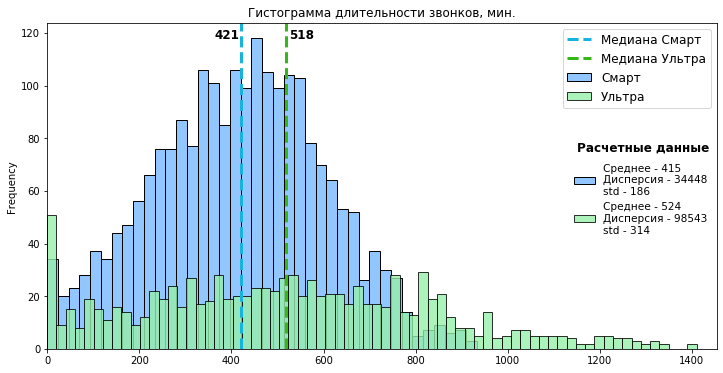

In [65]:
plot_hist_comparison('Звонки')

<font color=#0000FF>"Смарт":</font>

Требуется от 250 до 600 минут в месяц. Медиана - 421 минута. Большинство укладываются в доступный лимит.

<font color=#008000>"Ультра":</font>

Большинство клиентов используют голосовую связь по минимуму: медиана равна 518 минутам из 3000 доступных.

Гистограмма для СМС.

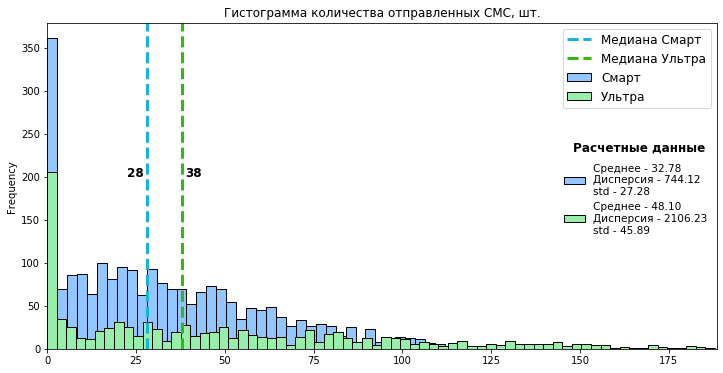

In [66]:
plot_hist_comparison('СМС')

<font color=#0000FF>"Смарт":</font>

Большинство клиентов вообще не отправляют СМС сообщения. Медиана - 28 штук. Среднее - 33 штуки. Лимит СМС полностью не используется.

<font color=#008000>"Ультра":</font>

Клиенты "Ультра" тоже предпочитают другие виды связи, но ситуация чуть лучше, чем у тарифа "Смарт". Медиана - 38 штук. Среднее - 46 штук. Лимит СМС полностью не используется.

Гистограмма для Интернета.

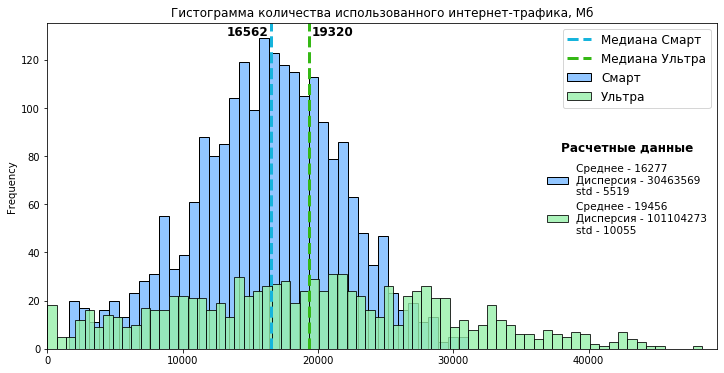

In [67]:
plot_hist_comparison('Интернет')

<font color=#0000FF>"Смарт":</font>

Медиана - 16.5Gb. Среднее - 16.2GB. Большинство клиентов постоянно превышаю лимит в 15Gb, и дозаказывают дополнительный трафик.

<font color=#008000>"Ультра":</font>

Медиана - 19.3Gb. Среднее - 19.4GB. Клиенты "Ультра" потребляют больше трафика, но не превышают лимит в 30Gb, и не дозаказывают дополнительный трафик.

##### Вывод 3

Клиентам <font color=#0000FF>"Смарт":</font> требуется в среднем 415 минут разговоров в месяц, что укладывается в предоставленный им лимит. Они почти не используют 'СМС', и среднее значение по ним составляет 32. Зато они регулярно пользуются интернетом: среднее значение равно 16.2Gb. Большинство дозаказывают интернет после исчерпания лимита.

Клиентам <font color=#008000>"Ультра":</font>  требуется в среднем 524 минуты разговоров в месяц, из 3000 предоставленных тарифом. Они чуть чаще использую СМС, отправляя в месяц в среднем 48 штук. Также они потребляю больше интернет трафика, чем клиенты "Смарт", но недостаточно, чтобы исчёрпать свой лимит: 19Gb в среднем, в лимит составляет 30Gb.

# Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

<font color=#008000>4.1 Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.</font>

Сформируем гипотезы:

- "Нулевая гипотеза" - средняя выручка от пользователей тарифа "Смарт" не отличается от выручки, полученной от пользователей тарифа "Ультра".
- "Альтернативная гипотеза" - средняя выручка от пользователей тарифа "Смарт" отличается от выручки, полученной от пользователей тарифа "Ультра".

Создадим гистограмму размаха со стандартным межквартильным размахом 1.5, что бы найти выбросы.

Text(0.5, 1, 'Boxplot по выручке с whis = 1,5')

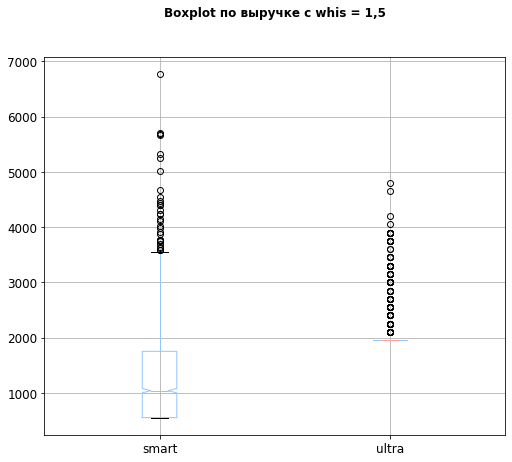

In [68]:
ax = client_actions_amount.boxplot(column = 'Сумма выручки за месяц', by = 'Тариф', fontsize=12,
                                   notch = True, figsize = (8, 7))
ax.set_title('')
ax.title.set_size(40)
ax.set_xlabel('')
plt.suptitle('Boxplot по выручке с whis = 1,5', y=1, fontsize=12, fontweight='bold')

Найдём границы интервалов.

In [69]:
revenue_int_smart, revenue_int_ultra = intervals('Сумма выручки за месяц', 'Тариф')

Границы интервала для столбца "Сумма выручки за месяц" тарифа "Смарт": 0.0 - 3550.0
Границы интервала для столбца "Сумма выручки за месяц" тарифа "Ультра": 1950.0 - 1950.0


Посчитаем среднюю месячную выручку по тарифам "Смарт" и "Ультра".

In [70]:
smart_revenue_mean = client_actions_amount[(client_actions_amount['Тариф'] == 'smart') &
                                      (client_actions_amount['Сумма выручки за месяц'] >= revenue_int_smart[0]) &
                                      (client_actions_amount['Сумма выручки за месяц'] <= revenue_int_smart[1])]['Сумма выручки за месяц']

ultra_revenue_mean = client_actions_amount[(client_actions_amount['Тариф'] == 'ultra') &
                                      (client_actions_amount['Сумма выручки за месяц'] >= revenue_int_ultra[0]) &
                                      (client_actions_amount['Сумма выручки за месяц'] <= revenue_int_ultra[1])]['Сумма выручки за месяц']

Расчитаем p-value, и подтвердим одну из гипотез. Выборки у нас независимые, поэтому используем функцию ttest_ind. Пороговым значением alpha будет 0.05.

In [71]:
stat, p = ttest_ind(smart_revenue_mean, ultra_revenue_mean)
print('t = {}\np-value = {:.10e}'.format(stat, p))

t = -27.93259650896307
p-value = 4.6244593529e-153


Нулевая гипотеза отвергнута. Средняя выручка от тарифов "Смарт" и "Ультра" различается.

In [72]:
smart_revenue_mean.mean()

1249.741010468821

In [73]:
ultra_revenue_mean.mean()

1950.0

<font color=#008000>4.2 Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.</font>

Сформируем гипотезы:

- "Нулевая гипотеза" - средняя выручка от пользователей из Москвы не отличается от выручки, полученной от пользователей из других регионов.
- "Альтернативная гипотеза" - средняя выручка от пользователей из Москвы отличается от выручки, полученной от пользователей из других регионов.

Добавим в таблицу колонку с принадлежностью клиентов к Москве или регионам.

In [74]:
client_actions_amount['Москвич'] = np.where(client_actions_amount['Город'] == 'Москва', 1, 0)

In [75]:
client_actions_amount.head()

,User_id,Месяц,Количество звонков,Длительность звонков в мин.,СМС,Интернет,Тариф,Город,Абонентская плата,Минуты сверх лимита,СМС сверх лимита,МБ сверх лимита,Плата сверх лимита,Сумма выручки за месяц,Москвич
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0


Создадим гистограмму размаха со стандартным межквартильным размахом 1.5, что бы найти выбросы.

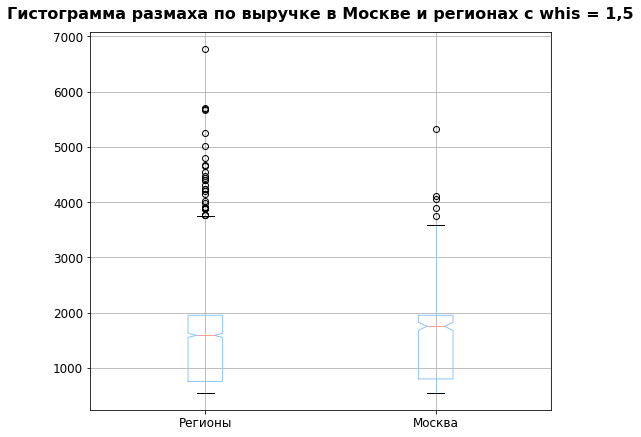

In [76]:
ax = client_actions_amount.boxplot(column = 'Сумма выручки за месяц', by = 'Москвич', fontsize=12,
                                   notch=True, figsize=(8,7))



labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Регионы'
labels[1] = 'Москва'

ax.set_xticklabels(labels)

plt.suptitle('Гистограмма размаха по выручке в Москве и регионах с whis = 1,5', y=0.95, fontsize=16, fontweight='bold')

ax.set_xlabel('')
ax.set_title('')
ax.title.set_size(40)

Найдём границы интервалов.

In [77]:
revenue_int_smart, revenue_int_ultra = intervals('Сумма выручки за месяц', 'Москвич')

Границы интервала для столбца "Сумма выручки за месяц" для регионов: 550.0 - 3750.0
Границы интервала для столбца "Сумма выручки за месяц" для Москвы: 550.0 - 3678.0


Посчитаем среднюю месячную выручку от Москвичей и жителей регионов.

In [78]:
moscow_revenue_mean = client_actions_amount[(client_actions_amount['Город'] == 'Москва') &
                     (client_actions_amount['Сумма выручки за месяц'] >= revenue_int_smart[0]) &
                     (client_actions_amount['Сумма выручки за месяц'] <= revenue_int_smart[1])]['Сумма выручки за месяц']

region_revenue_mean = client_actions_amount[(client_actions_amount['Город'] != 'Москва') &
                     (client_actions_amount['Сумма выручки за месяц'] >= revenue_int_ultra[0]) &
                     (client_actions_amount['Сумма выручки за месяц'] <= revenue_int_ultra[1])]['Сумма выручки за месяц']

Расчитаем p-value, и подтвердим одну из гипотез. Выборки у нас независимые, поэтому используем функцию ttest_ind. Пороговым значением alpha будет 0.05.

In [79]:
stat, p = ttest_ind(moscow_revenue_mean, region_revenue_mean)
print('t = {}\np-value = {:.10e}'.format(stat, p))

t = 1.49291699198228
p-value = 1.3555855818e-01


Нулевая гипотеза подтверждена - средняя выручка от клиентов из Москвы не отличается от средней выручки, полученной от клиентов из регионов.

In [80]:
moscow_revenue_mean.mean()

1532.3805601317956

In [81]:
region_revenue_mean.mean()

1483.282702069504

##### Вывод 4

Перед нами стиояла задача проверить следующие гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Мы сформировали нулевую и альтернативную гипотезу для каждого из утверждений.

Для "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается":
- "Нулевая гипотеза" - средняя выручка от пользователей тарифа "Смарт" не отличается от выручки, полученной от пользователей тарифа "Ультра".
- "Альтернативная гипотеза" - средняя выручка от пользователей тарифа "Смарт" отличается от выручки, полученной от пользователей тарифа "Ультра".

Нулевая гипотеза была отвергнута, т.к. выручки у "Смарт" и "Ультра" различаются.

Для "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов":
- "Нулевая гипотеза" - средняя выручка от пользователей из Москвы не отличается от выручки, полученной от пользователей из других регионов.
- "Альтернативная гипотеза" - средняя выручка от пользователей из Москвы отличается от выручки, полученной от пользователей из других регионов.

Нулевая гипотеза подтвердилась - средняя выручка от клиентов из Москвы не отличается от средней выручки, полученной от клиентов из регионов.

# Шаг 5. Общий вывод.

#### Вывод 1

Мы изучили данные в таблицах calls, internet, messages, tariffs и users. Следующим колонкаи требуется перевод в datetime:
- call_date в 'calls'
- session_date в 'internet'
- message_date в 'messages'
- ref_date в 'users'

Были обнаружены пропуски в колонке users['churn_date']. Отсутствие данных в этой колонке говорит о том, что у клиента "Мегалайна", на момент выгрузки данных, тариф ещё действовал. Эти пропуски нам не помешают.

Также в таблицах 'calls' и 'internet' слишком много околонулевых значений длительности звонков и потребления интернета.

##### Вывод 2

Мы перевели в datetime следующие колонки:
- call_date в 'calls'
- session_date в 'internet'
- message_date в 'messages'
- ref_date в 'users'

Также в эти таблицы были добавлены колонка 'месяц'.

В колонках calls['duration'] и internet['mb_used'] было обнаружино множество околонулевых значений. После анализа мы пришли к выводу, что они появились в следствии того, что клиенты иногда просто не пользовались определёнными типами связи. Эти значения были заменены на NaN.

Также мы создали таблицу client_actions_amount, собирающую в себе следующую информацию о клиентах:
- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя

##### Вывод 3

Клиентам <font color=#0000FF>"Смарт":</font> требуется в среднем 415 минут разговоров в месяц, что укладывается в предоставленный им лимит. Они почти не используют 'СМС', и среднее значение по ним составляет 32. Зато они регулярно пользуются интернетом: среднее значение равно 16.2Gb. Большинство дозаказывают интернет после исчерпания лимита.

Клиентам <font color=#008000>"Ультра":</font>  требуется в среднем 524 минуты разговоров в месяц, из 3000 предоставленных тарифом. Они чуть чаще использую СМС, отправляя в месяц в среднем 48 штук. Также они потребляю больше интернет трафика, чем клиенты "Смарт", но недостаточно, чтобы исчёрпать свой лимит: 19Gb в среднем, в лимит составляет 30Gb.

##### Вывод 4

Перед нами стиояла задача проверить следующие гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Мы сформировали нулевую и альтернативную гипотезу для каждого из утверждений.

Для "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается":
- "Нулевая гипотеза" - средняя выручка от пользователей тарифа "Смарт" не отличается от выручки, полученной от пользователей тарифа "Ультра".
- "Альтернативная гипотеза" - средняя выручка от пользователей тарифа "Смарт" отличается от выручки, полученной от пользователей тарифа "Ультра".

Нулевая гипотеза была отвергнута, т.к. выручки у "Смарт" и "Ультра" различаются.

Для "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов":
- "Нулевая гипотеза" - средняя выручка от пользователей из Москвы не отличается от выручки, полученной от пользователей из других регионов.
- "Альтернативная гипотеза" - средняя выручка от пользователей из Москвы отличается от выручки, полученной от пользователей из других регионов.

Нулевая гипотеза подтвердилась - средняя выручка от клиентов из Москвы не отличается от средней выручки, полученной от клиентов из регионов.